<a href="https://colab.research.google.com/github/Crissomar1/AntiSpamAI/blob/main/Proyect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IA AntiSpam
<details>
<summary>The project involves the following key components:</summary>

1. Data Collection: Gathering a diverse and representative dataset of spam and non-spam messages to train the machine learning models.

2. Data Preprocessing: Cleaning and preprocessing the collected data to remove noise, standardize formats, and extract relevant features.

3. Feature Engineering: Transforming the preprocessed data into a suitable format for training the machine learning models, including the extraction of text-based features such as word frequency, n-grams, and semantic analysis.

4. Model Training: Developing and training machine learning models using various algorithms such as Naive Bayes, Support Vector Machines, or Deep Learning models like Recurrent Neural Networks (RNNs) or Transformers.

5. Model Evaluation: Assessing the performance of the trained models using appropriate evaluation metrics such as accuracy, precision, recall, and F1-score.

6. Model Deployment: Integrating the trained model into a production environment, such as an email server or messaging platform, to automatically classify incoming messages as spam or non-spam.
</details>






## Imports

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import random
import os
import mailbox
from collections import Counter

nltk.download('stopwords')  # Uncomment if stopwords haven't been downloaded
nltk.download('wordnet')  # Uncomment if WordNetLemmatizer isn't present

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Data Collection

In [ ]:
# install required packages
!sudo apt update
!sudo apt install unrar
# unrar spam.rar and easy_ham.rar on data folder
if not os.path.exists('spam.rar'):
    !wget https://raw.githubusercontent.com/Crissomar1/AntiSpamAI/main/spam.rar
if not os.path.exists('easy_ham.rar'):
    !wget https://raw.githubusercontent.com/Crissomar1/AntiSpamAI/main/easy_ham.rar
!unrar x spam.rar spam/
!unrar x easy_ham.rar easy_ham/

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:5 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
46 packages can be upgraded. Run 'apt list --upgradable' to see them.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
u

## Data preprocesing

In [ ]:
email_list = []
carpetas = ['easy_ham', 'spam']
for carpeta in carpetas:
    for archivo in os.listdir(carpeta):
        # Abrir el archivo como un buzón de correo
        mbox = mailbox.mbox(carpeta + '/' + archivo)
        # Agregar cada correo en el buzón a la lista de correos
        for correo in mbox:
            email_list.append(correo)
    #guardar la cantidad de correos en cada carpeta en ua variable
    if carpeta == 'easy_ham':
        easy_ham_count = len(email_list)
    else:
        spam_count = len(email_list) - easy_ham_count

print("Correos Cargados")

def flatten_payload(email):
    email_text = email.get_payload()
    if isinstance(email_text, list):
        return ' '.join(flatten_payload(part) for part in email_text)
    else:
        return email_text


def preprocess_email(email):
    email_text = email.get_payload()
    email_text = flatten_payload(email)
    # 1. Conversión a minúsculas:
    email_text = email_text.lower()

    # 2. Eliminación de caracteres especiales y URLs:
    email_text = re.sub(r'[^a-z0-9\s]', ' ', email_text)  # Sustituye caracteres especiales
    email_text = re.sub(r'http\S+', ' ', email_text)  # Elimina URLs

    # 3. Tokenización (separa el texto en palabras):
    words = email_text.split()

    # 4. Eliminación de stopwords (palabras de enlace frecuentes):
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]

    # 5. Lematización (reduce palabras a su raíz):
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]

    return ' '.join(words)

def create_vocabulary(email_list, frequency_threshold=5):
    # Initialize a Counter object to store word frequencies
    word_freq = Counter()

    # Iterate over each email in the list
    for email in email_list:
        # Convert the email into a list of preprocessed words
        words = preprocess_email(email).split()

        # Update word frequencies
        word_freq.update(words)

    # Filter out uncommon words
    vocab_list = [word for word, freq in word_freq.items() if freq >= frequency_threshold]

    # Sort the vocabulary list
    vocab_list.sort()

    return vocab_list


# Guarda el vocabulario en un archivo de texto
if os.path.exists('vocab.txt'):
    with open('vocab.txt', 'r') as f:
        vocab = [line.strip() for line in f]
    print("Vocabulario Cargado")
else:
    vocab = create_vocabulary(email_list,5)
    with open('vocab.txt', 'w') as f:
        for word in vocab:
            f.write(word + '\n')
    print("Vocabulario creado y guardado")



Correos Cargados
Vocabulario Cargado


## Data Encoding

In [ ]:
def one_hot_encode(text, vocab_dict):
    # Convierte el texto en una lista de palabras preprocesadas
    words = preprocess_email(text)

    # Crea un vector de ceros del tamaño del vocabulario
    encoded_email = np.zeros(len(vocab))

    # Asigna 1 a la posición correspondiente a cada palabra en el vocabulario
    for word in words:
        if word in vocab_dict:
            encoded_email[vocab_dict[word]] = 1

    return encoded_email

def DataFrame_GEN(email_list, spam_count, easy_ham_count):
    # Divide la lista de correos en correos de spam y ham
    spam_emails = email_list[:spam_count]
    ham_emails = email_list[spam_count:]

    # Agrega los correos electrónicos codificados a un DataFrame

    # Crea un DataFrame para almacenar los correos electrónicos y sus etiquetas
    email_df = pd.DataFrame(columns=['text', 'label'])

    # Crea una lista de correos electrónicos codificados
    encoded_emails = []
    vocab_dict = {word: i for i, word in enumerate(vocab)}

    # Codifica los correos electrónicos de spam
    encoded_emails = [one_hot_encode(email, vocab_dict) for email in spam_emails]

    print("Spam Codificado")

    # Codifica los correos electrónicos de ham
    encoded_emails += [one_hot_encode(email, vocab_dict) for email in ham_emails]

    print("Ham Codificado")

    # Agrega los correos electrónicos codificados al DataFrame

    email_df['text'] = encoded_emails
    email_df['label'] = ['spam'] * spam_count + ['ham'] * easy_ham_count

    # Guarda el DataFrame en un archivo CSV
    email_df.to_pickle('emails.pkl')

if os.path.exists('emails.pkl'):
    email_df = pd.read_pickle('emails.pkl')
    print("DataFrame Cargado")
else:
    DataFrame_GEN(email_list, spam_count, easy_ham_count)
    print("DataFrame Creado y Guardado")

DataFrame Cargado


## Model Trainig

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras import layers
from keras import Input

with open('vocab.txt', 'r') as file:
    vocab = file.read().splitlines()

# Read the emails.pkl dataframe
emails_df = pd.read_pickle('emails.pkl')

# use Random Oversampling Ensembles to balance the dataset
spam_df = emails_df[emails_df['label'] == 'spam']
ham_df = emails_df[emails_df['label'] == 'ham']

# Oversample the spam emails
spam_df = spam_df.sample(len(ham_df), replace=True)

# Combine the oversampled spam emails with the ham emails
emails_df = pd.concat([spam_df, ham_df])

# Shuffle the dataframe
emails_df = emails_df.sample(frac=1).reset_index(drop=True)

# change emails_df['label'] to 1 and 0
emails_df['label'] = emails_df['label'].apply(lambda x: 1 if x == 'spam' else 0)

# Separate the data into train, test, and evaluation sets
train_set, test_set = train_test_split(emails_df, test_size=0.2)
test_set, eval_set = train_test_split(test_set, test_size=0.5)


# Create he anti-spam AI model
model = keras.Sequential([
    Input(shape=(len(vocab),)),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# matrix with the encoded emails
X = np.array(train_set['text'].to_list())

Y = np.array(train_set['label'].to_list())

X_val = np.array(test_set['text'].to_list())
y_val = np.array(test_set['label'].to_list())

# Train the model
model.fit(X, Y, epochs=200,validation_data=(X_val, y_val))

# Save the model
model.save('spam_model.keras')


ModuleNotFoundError: No module named 'tensorflow'

## Evaluate the model

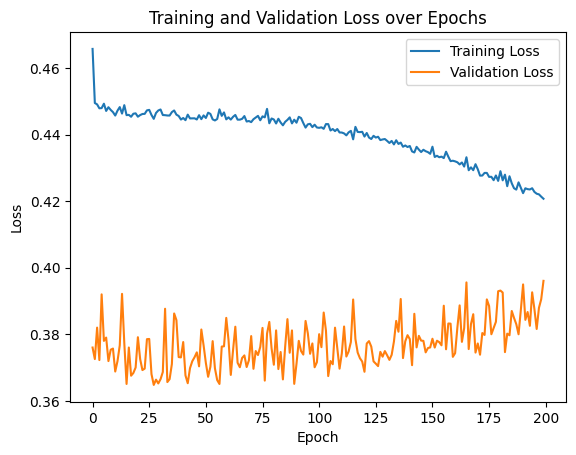

56/56 [==============================] - 0s 5ms/step
[[1.485e+03 0.000e+00]
 [2.940e+02 1.000e+00]]


In [ ]:
# Evaluate the model
# X = np.array(eval_set['text'].to_list())
# Y = np.array(eval_set['label'].to_list())
# X = np.array(emails_df['text'].to_list())
# Y = np.array(emails_df['label'].to_list())

# model.evaluate(X, Y)

import matplotlib.pyplot as plt
history = model.history
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')

# Add labels and title
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')

# Add legend and show plot
plt.legend()
plt.show()
# confusion matrix

predictions = model.predict(X)
predictions = (predictions > 0.5).astype(int)

confusion_matrix = np.zeros((2, 2))
for i in range(len(Y)):
    confusion_matrix[Y[i]][predictions[i]] += 1
print(confusion_matrix)
